In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from typing import List

plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

In [24]:
def cargar_datos(file_name : str) -> list:
    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de frecuencia que alimentamos con el generador de funciones
    freq_values_keys = list(dic.keys())
    # Le sacamos la "Hz" a las keys
    freq_values = [float(freq[:-2]) for freq in freq_values_keys]
    t1, V1 = [dic[f'{freq}Hz']['t_1'] for freq in freq_values], [dic[f'{freq}Hz']['V_1'] for freq in freq_values]
    t2, V2 = [dic[f'{freq}Hz']['t_2'] for freq in freq_values], [dic[f'{freq}Hz']['V_2'] for freq in freq_values]
    amp1 = np.array([np.max(v1)-np.min(v1) for v1 in V1]) # para ver los datos sobre la hora, hay que calcular bien esto
    amp2 = np.array([np.max(v2)-np.min(v2) for v2 in V2]) # para ver los datos sobre la hora, hay que calcular bien esto

    scale_1 = [dic[freq]["scale"][0] for freq in freq_values_keys]

    scale_2 = [dic[freq]["scale"][1] for freq in freq_values_keys]

    amp1_err = np.array([np.sqrt((0.004*max(v1)+ 3/1000 + 0.1*scale_1[i])**2+(0.004*min(v1)+ 3/1000 + 0.1*scale_1[i])**2) for i,v1 in enumerate(V1)])
    # print(max(V2[-1]),0.004*max(V2[-1])+ 3/1000 + 0.1*scale_2[0])
    # print(amp1[-1], amp1_err[-1])
    # print("\n")

    # print((0.004*max(V2[-1])+ 3/1000 + 0.1*scale_2[0])/max(V1[-1]))
    amp2_err = np.array([np.sqrt((0.004*max(v2)+ 3/1000 + 0.1*scale_2[i])**2+(0.004*min(v2)+ 3/1000 + 0.1*scale_2[i])**2) for i,v2 in enumerate(V2)])
    # print(amp2[-1], amp2_err[-1])
    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [freq_values, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err]

    return lista_mediciones

In [25]:
a= cargar_datos("../mediciones/D.D/Tiempo de respuesta del laser/Barrido sinusoidal 02-06.pickle")


In [20]:
file_names = ["Fuente de corriente/Barrido sinusoidal a 0.5 V de amp y 2 V de offset.pickle",
              "Tiempo de respuesta del laser/Barrido sinusoidal a 0.5 V de amp y 2 V de offset con R=50 ohm.pickle"]
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]
freqs = []
Ts = []

def sin_func(t:list, A: float, w: float,phi: float):
    return abs(A)*np.sin(w*np.array(t)+phi)

def ajustar_sinusoidales(t: List[np.ndarray], V: List[np.ndarray], freq_list: List[np.ndarray]):
    amp_list = []
    for i in range(len(V)):
        suggested_amp = (max(V[i]-np.mean(V[i]))-min(V[i]-np.mean(V[i])))/2
        suggested_w = 2*np.pi*freq_list[i]
        popt, pcov = curve_fit(sin_func, t[i], V[i]-np.mean(V[i]),p0 = [suggested_amp, suggested_w, 1], bounds =([suggested_amp-0.001, suggested_w-10,-np.inf], [suggested_amp+0.001, suggested_w+10, np.inf]), maxfev = 5000)

        amp = popt[0]

        print(f"La frec es {popt[1]/(2*np.pi)} sugerida: {suggested_w/(2*np.pi)}")
        print(f"La amp es {popt[0]} amp sugerida {suggested_amp}")
        amp_list.append(amp)
        plt.figure()
        plt.plot(t[i], V[i]-np.mean(V[i]),".")
        plt.plot(t[i], sin_func(t[i],*popt), "--k")
        plt.show()
    return amp_list

In [3]:
# ajustar_sinusoidales(t1, V1, f)



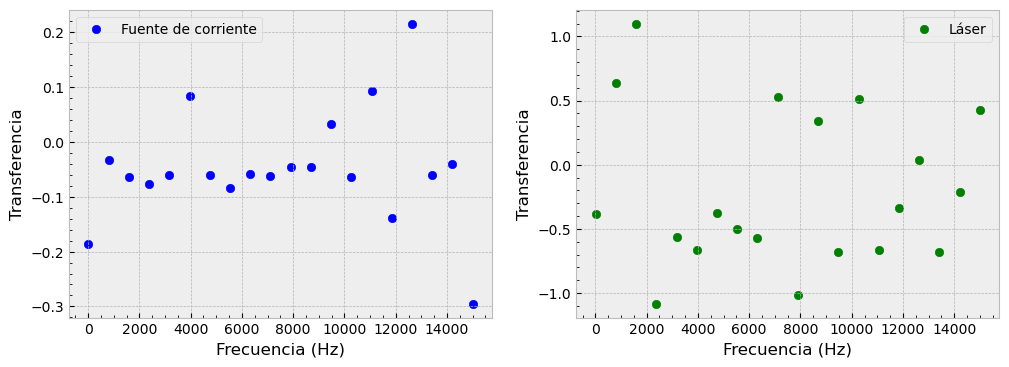

In [26]:
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]
freqs = []
Ts = []

fig, axs = plt.subplots(1,len(labels), figsize=(12,4))
for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{file_names[i]}"
    f, t1, V1, t2, V2, amp1, amp2 = cargar_datos(file_name)

    amp1 = ajustar_sinusoidales(t1, V1, f)
    amp2 = ajustar_sinusoidales(t2, V2, f)
    
    T = np.array(amp2)/np.array(amp1)
    freqs.append(f)
    Ts.append(T)
    ax.scatter(freqs[i], Ts[i], label=f'{labels[i]}', color = f"{colors[i]}")

    ax.set_ylabel('Transferencia') 
    ax.set_xlabel('Frecuencia (Hz)')
    # ax.title(f'R={R}')
    # ax.xscale("log")
    ax.legend()
plt.show()

# Método sin ajustar

[1.04 1.04 1.02 1.02 1.02 1.04 1.02 1.04 1.04 1.04 1.02 1.02 1.04 1.02
 1.04 1.04 1.04 1.04 1.04 1.06 1.06 1.06 1.06 1.06 1.04 1.08 1.08 1.06
 1.08 1.08]
[0.09773815 0.09773815 0.09779301 0.09779301 0.09779301 0.09773815
 0.09779301 0.09773815 0.09773815 0.09773815 0.09779301 0.09779301
 0.09773815 0.09779301 0.09773815 0.09773815 0.09773815 0.09773815
 0.09773815 0.09768333 0.09779641 0.09779641 0.09779641 0.09768333
 0.09773815 0.09762854 0.09762854 0.09768333 0.09774162 0.09774162]
[0.062 0.066 0.062 0.062 0.062 0.062 0.062 0.062 0.064 0.06  0.062 0.064
 0.062 0.062 0.062 0.062 0.062 0.062 0.064 0.062 0.062 0.064 0.06  0.064
 0.056 0.054 0.048 0.036 0.028 0.022]
[0.01006507 0.01007659 0.01006507 0.01006507 0.01006507 0.01006507
 0.01006507 0.01006507 0.01005952 0.01005932 0.01006507 0.01007083
 0.01006507 0.01006507 0.01006507 0.01006507 0.01006507 0.01006507
 0.01005952 0.01006507 0.01006507 0.01005952 0.01005932 0.01005952
 0.01005913 0.01005339 0.0100588  0.0100584  0.0100582  0.

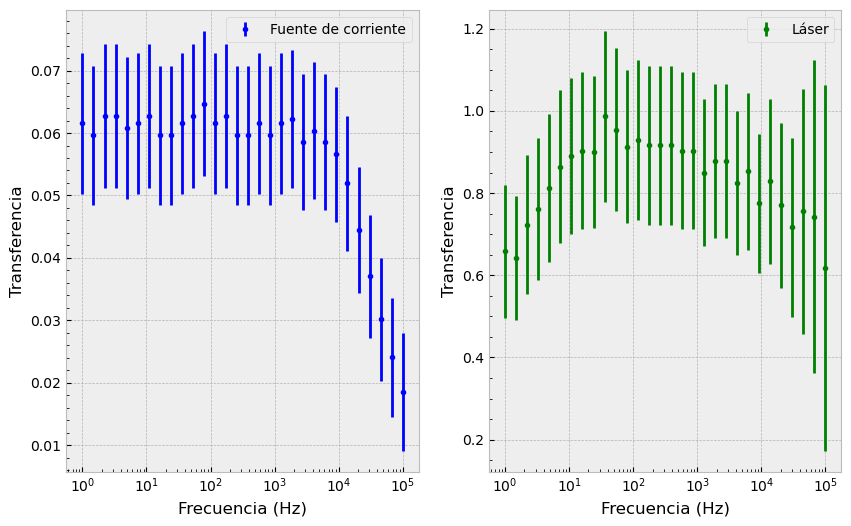

In [53]:
carpetas = ["Fuente de corriente", "Tiempo de respuesta del laser"] # La R del fotodiodo era de 50 Ohm
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]
Ts = []

fig, axs = plt.subplots(ncols = 2, figsize = (10,6))

for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[i]}/Barrido sinusoidal 02-06.pickle"
    freqs, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err = cargar_datos(file_name)
    print(amp1)
    print(amp1_err)
    T = amp2/amp1
    # T_err = np.sqrt((amp2_err/amp1)**2+((amp2/(amp1**2))*amp1_err)**2)
    T_err = T*np.sqrt((amp1_err/amp1)**2+(amp2_err/amp2)**2)
    Ts.append(T)
    ax.errorbar(freqs, T, yerr = T_err, color = colors[i], label = labels[i], fmt = ".")
    # ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel('Transferencia') 
    ax.set_xlabel('Frecuencia (Hz)')
    # ax.title(f'R={R}')
    ax.legend()
plt.show()

0.064 0.01002558008296777
0.0408 0.0075720131431476


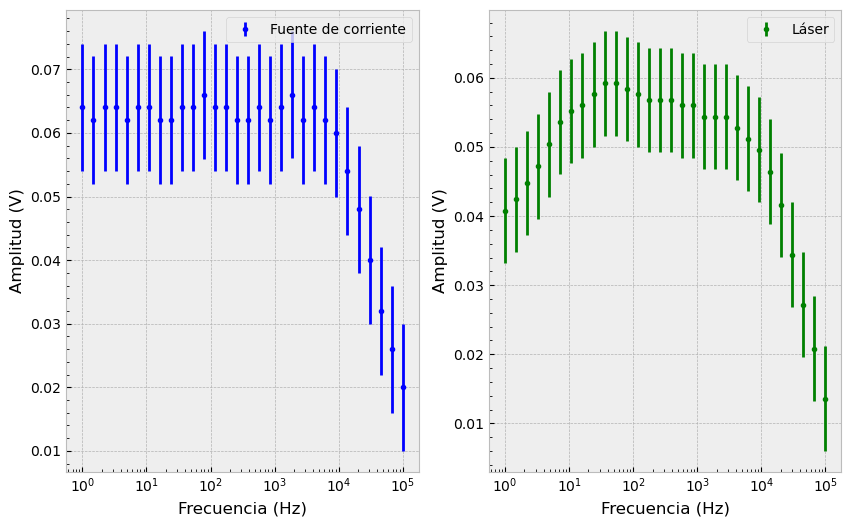

In [26]:
carpetas = ["Fuente de corriente", "Tiempo de respuesta del laser"] # La R del fotodiodo era de 50 Ohm
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]
Ts = []

fig, axs = plt.subplots(ncols = 2, figsize = (10,6))

for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[i]}/Barrido sinusoidal 02-06.pickle"
    freqs, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err = cargar_datos(file_name)
    print(amp2[0], amp2_err[0])



    ax.errorbar(freqs, amp2, yerr = amp2_err, color = colors[i], label = labels[i], fmt = ".")
    # ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel('Amplitud (V)') 
    ax.set_xlabel('Frecuencia (Hz)')
    ax.legend()
plt.show()